In [1]:
# importing libraries
import pandas as pd
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
#import statsmodels.api as sm
import numpy as np

from sklearn.utils import shuffle
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn import metrics, preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
# basic loadning
data_dir = "../data"
class_labels = ['Ec','Ei','Er','SBa','SBb','SBc','SBd','Sa','Sb','Sc','Sd','Se']

df = pd.read_csv(data_dir + "/categorized.csv")
include_columns = ["PETROR90_R", "PETROMAG_R", "PETROMAG_U", "PETROMAGERR_U", "PETROMAGERR_R", "PETROMAGERR_Z", "PSFMAG_R", "DEVMAGERR_R", 
                   "FRACDEV_R", "EXTINCTION_R", "ROWC_R", "COLC_R", "CMODELMAGERR_R", "REDSHIFT", "REDSHIFTERR", "REDSHIFT_SIMPLE_BIN", "PETROMAG_MR", 
                   "PETROMAGERR_MU", "PETROMAGERR_MR", "PETROMAGERR_MZ", "PETROR50_R_KPC_SIMPLE_BIN", "WVT_BIN"]
label_column = ["code"]
df = df[include_columns + label_column]

In [3]:
def handle_limits_by_groups(dframe, group_column, limit_values = {}):
    distinct = set(dframe[group_column].unique())
    
    for v in distinct:
        for col in limit_values:
            # get data indexes of limit column values per class
            inx = dframe[(dframe["code"] == v) & (dframe[col] == limit_values[col])].index
            # clean above index values to obtain the mean value 
            tmp_df = dframe.drop(inx)
            # set the mean value in the original frame for the identified index rows
            dframe.loc[inx, col] = tmp_df[col].mean()

    print("Limit adjustment completed")

def handle_outliers_by_groups(dframe, group_column, omit_columns):
    distinct = set(dframe[group_column].unique())
    
    for v in distinct:
        tmp_df = dframe[dframe["code"] == v]
        tmp_df = tmp_df.drop(columns=omit_columns)
        q1 = tmp_df.quantile(0.25)
        q3 = tmp_df.quantile(0.75)
        irq = q3 - q1
        lower_limit = q1 - (1.5 * irq)
        upper_limit = q3 + (1.5 * irq)
        
        # adjust the outlier value for each column
        for col in tmp_df.columns:
            tmp_df[col].astype('float64').dtypes
            dframe[col].astype('float64').dtypes
            tmp_df.loc[tmp_df[col] < lower_limit[col], col] = lower_limit[col]
            tmp_df.loc[tmp_df[col] > upper_limit[col], col] = upper_limit[col]
            dframe.loc[tmp_df.index, col] = tmp_df[col]

In [4]:
# handling min/max limits
limit_values = {"REDSHIFT_SIMPLE_BIN": 999, "PETROMAGERR_MU": 99999, "PETROMAGERR_MZ": 99999, "PETROR50_R_KPC_SIMPLE_BIN": 999}
handle_limits_by_groups(df, "code", limit_values)

# call and pass the dataset to handle outliers in the numerical columns    
handle_outliers_by_groups(df, "code", ["code"])

Limit adjustment completed


In [5]:
df = shuffle(df, random_state=42)
x_transformed = df[include_columns].copy()

std_scaler = preprocessing.StandardScaler()
scaled_values = std_scaler.fit_transform(x_transformed)
scaled_df = pd.DataFrame(scaled_values, columns=list(x_transformed.columns))
scaled_df.head(5)

,PETROR90_R,PETROMAG_R,PETROMAG_U,PETROMAGERR_U,PETROMAGERR_R,PETROMAGERR_Z,PSFMAG_R,DEVMAGERR_R,FRACDEV_R,EXTINCTION_R,...,CMODELMAGERR_R,REDSHIFT,REDSHIFTERR,REDSHIFT_SIMPLE_BIN,PETROMAG_MR,PETROMAGERR_MU,PETROMAGERR_MR,PETROMAGERR_MZ,PETROR50_R_KPC_SIMPLE_BIN,WVT_BIN
0,0.876054,-1.228346,-0.816357,-0.735778,-0.824703,-0.938303,-0.244308,-1.056993,-0.464686,-1.247787,...,-1.459340,0.374265,0.357722,0.368308,-1.261026,-0.740847,-0.685394,-0.915202,1.826146,1.080151
1,1.814714,-1.922352,-1.556738,-0.864561,-0.899108,-0.753509,-1.299585,-1.348972,0.746916,-0.618052,...,-1.166051,-0.301259,0.966769,-0.364635,-0.964215,-0.865525,-0.722829,-0.751253,1.024203,2.278893
2,-1.395767,0.417612,0.486647,-0.805468,-0.544367,-0.923607,-0.952746,-0.577977,0.907868,-0.906097,...,-0.247215,-0.930743,-1.438400,-0.853263,1.320699,-0.808490,-0.509939,-0.902530,-1.531989,-0.837836
3,1.148669,-1.644922,-0.468655,-0.418649,-0.903241,-1.136848,-1.227441,-1.342616,0.907868,2.582968,...,-1.071282,0.048195,0.891515,0.123994,-1.345472,-0.428184,-0.724782,-1.077955,0.623232,2.141894
4,-1.176043,0.817217,1.410437,0.522338,1.103240,-0.347262,-0.233274,-0.029329,0.907868,2.549306,...,0.344075,0.248903,0.494395,0.123994,-0.196589,0.518605,1.063734,-0.366381,-0.880411,-0.632337


In [6]:
# Uniform strategy is used to form 1000 bins
# Notice x-axis values were transformed to positive and y-axis relatively scaled

kbins = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform', subsample=None)
x_discrete = kbins.fit_transform(scaled_df)
x_discrete = pd.DataFrame(x_discrete, columns=list(x_transformed.columns))
x_discrete

,PETROR90_R,PETROMAG_R,PETROMAG_U,PETROMAGERR_U,PETROMAGERR_R,PETROMAGERR_Z,PSFMAG_R,DEVMAGERR_R,FRACDEV_R,EXTINCTION_R,...,CMODELMAGERR_R,REDSHIFT,REDSHIFTERR,REDSHIFT_SIMPLE_BIN,PETROMAG_MR,PETROMAGERR_MU,PETROMAGERR_MR,PETROMAGERR_MZ,PETROR50_R_KPC_SIMPLE_BIN,WVT_BIN
0,43.0,32.0,34.0,18.0,6.0,7.0,41.0,15.0,48.0,10.0,...,10.0,39.0,57.0,37.0,20.0,15.0,2.0,4.0,76.0,59.0
1,58.0,18.0,21.0,16.0,5.0,9.0,27.0,11.0,93.0,25.0,...,14.0,27.0,65.0,23.0,24.0,12.0,1.0,6.0,60.0,88.0
2,6.0,64.0,56.0,17.0,9.0,8.0,31.0,21.0,99.0,18.0,...,25.0,15.0,34.0,13.0,55.0,14.0,4.0,4.0,9.0,13.0
3,48.0,24.0,40.0,25.0,5.0,5.0,27.0,11.0,99.0,97.0,...,15.0,33.0,64.0,32.0,19.0,22.0,1.0,3.0,52.0,85.0
4,10.0,72.0,72.0,45.0,31.0,14.0,41.0,28.0,99.0,97.0,...,33.0,36.0,59.0,32.0,34.0,43.0,24.0,10.0,22.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239095,13.0,65.0,53.0,19.0,9.0,9.0,36.0,35.0,99.0,23.0,...,40.0,42.0,54.0,41.0,31.0,16.0,3.0,6.0,31.0,7.0
239096,33.0,58.0,58.0,56.0,19.0,20.0,50.0,33.0,69.0,72.0,...,29.0,50.0,48.0,46.0,22.0,54.0,13.0,16.0,85.0,47.0
239097,33.0,54.0,49.0,47.0,23.0,13.0,50.0,25.0,12.0,76.0,...,23.0,12.0,31.0,9.0,55.0,45.0,17.0,9.0,22.0,17.0
239098,29.0,57.0,52.0,33.0,11.0,12.0,41.0,23.0,99.0,44.0,...,28.0,23.0,60.0,18.0,43.0,30.0,5.0,8.0,27.0,27.0


In [7]:
# split the data into train/test sets
train_X, test_X, train_y, test_y = train_test_split(x_discrete[include_columns], df["code"], test_size=0.2, random_state=42)
test_X

,PETROR90_R,PETROMAG_R,PETROMAG_U,PETROMAGERR_U,PETROMAGERR_R,PETROMAGERR_Z,PSFMAG_R,DEVMAGERR_R,FRACDEV_R,EXTINCTION_R,...,CMODELMAGERR_R,REDSHIFT,REDSHIFTERR,REDSHIFT_SIMPLE_BIN,PETROMAG_MR,PETROMAGERR_MU,PETROMAGERR_MR,PETROMAGERR_MZ,PETROR50_R_KPC_SIMPLE_BIN,WVT_BIN
31833,23.0,73.0,48.0,34.0,12.0,27.0,63.0,45.0,85.0,18.0,...,48.0,24.0,60.0,23.0,49.0,31.0,6.0,23.0,43.0,56.0
10542,64.0,44.0,58.0,78.0,20.0,18.0,42.0,21.0,99.0,32.0,...,25.0,68.0,74.0,70.0,8.0,77.0,14.0,14.0,92.0,0.0
201211,28.0,71.0,77.0,99.0,26.0,15.0,48.0,31.0,99.0,24.0,...,36.0,68.0,58.0,99.0,19.0,99.0,17.0,11.0,66.0,0.0
34881,58.0,37.0,34.0,28.0,40.0,18.0,26.0,16.0,99.0,14.0,...,21.0,48.0,53.0,46.0,16.0,25.0,31.0,14.0,70.0,46.0
198984,5.0,75.0,67.0,33.0,10.0,10.0,39.0,31.0,94.0,51.0,...,33.0,29.0,59.0,27.0,44.0,31.0,5.0,6.0,16.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125381,40.0,70.0,53.0,71.0,24.0,41.0,54.0,47.0,53.0,22.0,...,35.0,37.0,51.0,32.0,36.0,70.0,17.0,38.0,57.0,75.0
176753,37.0,35.0,34.0,19.0,6.0,7.0,30.0,14.0,90.0,17.0,...,16.0,15.0,63.0,13.0,43.0,16.0,2.0,4.0,25.0,38.0
203876,20.0,70.0,63.0,35.0,27.0,16.0,47.0,30.0,99.0,28.0,...,35.0,33.0,53.0,32.0,39.0,32.0,20.0,13.0,29.0,12.0
71972,20.0,41.0,45.0,29.0,89.0,46.0,27.0,16.0,99.0,11.0,...,21.0,24.0,59.0,23.0,36.0,26.0,91.0,43.0,21.0,34.0


In [26]:
# preparing for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, AveragePooling1D

train_label = pd.get_dummies(train_y).values
test_label = pd.get_dummies(test_y).values

no_of_features = train_X.shape[1]
no_of_labels = len(set(train_y))

In [27]:
model = Sequential()

model.add(Conv1D(128, kernel_size=2, activation='relu', input_shape=(no_of_features,1)))
model.add(AveragePooling1D(pool_size=2))

model.add(Conv1D(256, kernel_size=2, activation='relu', input_shape=(no_of_features,)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(512, kernel_size=3, activation='relu', input_shape=(no_of_features,)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dense(no_of_labels, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_X, train_label, epochs=10, batch_size=20, validation_data=(test_X, test_label))

Epoch 1/10


/opt/anaconda/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9564/9564 ━━━━━━━━━━━━━━━━━━━━ 126s 13ms/step - accuracy: 0.4411 - loss: 1.4629 - val_accuracy: 0.5265 - val_loss: 1.2203
Epoch 2/10
9564/9564 ━━━━━━━━━━━━━━━━━━━━ 129s 13ms/step - accuracy: 0.5293 - loss: 1.1959 - val_accuracy: 0.5399 - val_loss: 1.1707
Epoch 3/10
9564/9564 ━━━━━━━━━━━━━━━━━━━━ 130s 14ms/step - accuracy: 0.5489 - loss: 1.1392 - val_accuracy: 0.5587 - val_loss: 1.1284
Epoch 4/10
9564/9564 ━━━━━━━━━━━━━━━━━━━━ 130s 14ms/step - accuracy: 0.5610 - loss: 1.1084 - val_accuracy: 0.5672 - val_loss: 1.0986
Epoch 5/10
9564/9564 ━━━━━━━━━━━━━━━━━━━━ 130s 14ms/step - accuracy: 0.5712 - loss: 1.0822 - val_accuracy: 0.5710 - val_loss: 1.0816
Epoch 6/10
9564/9564 ━━━━━━━━━━━━━━━━━━━━ 130s 14ms/step - accuracy: 0.5780 - loss: 1.0679 - val_accuracy: 0.5732 - val_loss: 1.0709
Epoch 7/10
9564/9564 ━━━━━━━━━━━━━━━━━━━━ 131s 14ms/step - accuracy: 0.5841 - loss: 1.0503 - val_accuracy: 0.5734 - val_loss: 1.0775
Epoch 8/10
9564/9564 ━━━━━━━━━━━━━━━━━━━━ 132s 14ms/step - accuracy: 0.5837 - lo

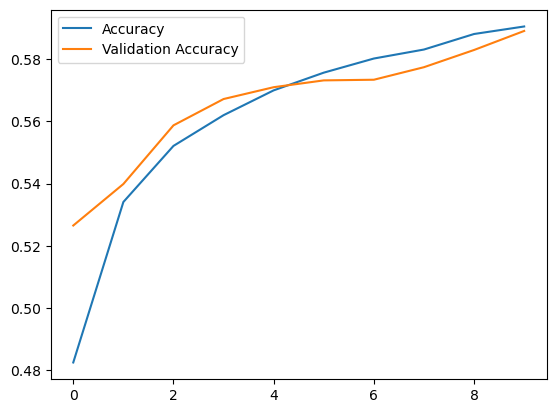

In [28]:
plt.plot(history.history['accuracy'], label="Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.show()

In [12]:
#predictions
predicted_y = model.predict(test_X)
predicted_y

1495/1495 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


array([[1.6228222e-13, 1.4411262e-09, 9.9999285e-01, ..., 2.8651061e-07,
        2.1656190e-14, 1.9170464e-12],
       [3.0164765e-21, 3.6178276e-02, 7.3346141e-29, ..., 1.5267653e-12,
        2.4190139e-09, 2.5925050e-18],
       [8.0747070e-32, 1.5098931e-34, 1.0000000e+00, ..., 2.7076550e-29,
        7.5106524e-24, 7.1187626e-12],
       ...,
       [2.0565601e-02, 8.2800567e-02, 3.8714312e-02, ..., 1.4996140e-01,
        5.8034561e-06, 1.4813200e-01],
       [1.1828484e-18, 0.0000000e+00, 0.0000000e+00, ..., 9.2528156e-34,
        1.7432290e-25, 1.0000000e+00],
       [4.8727274e-05, 3.9468752e-04, 9.6169252e-16, ..., 8.8292289e-01,
        5.8547815e-04, 4.7524617e-04]], dtype=float32)